<h1>
<center>CFRM 421/521, Spring 2022</center>
</h1>

<h1>
<center>[Insert your name here]</center>
</h1>

<h1>
<center>Homework 1</center>
</h1>

* **Due: Monday, April 18, 2022, 11:59 PM**


* Total marks: 46


* Late submissions are allowed, but a 20% penalty per day applies. Your last submission is considered for calculating the penalty.


*  Use this Jupyter notebook as a template for your solutions. **Your solution must be submitted as one Jupyter notebook.** The notebook must be already run, that is, make sure that you have run all your code, save the notebook, and then when you reopen the notebook, checked that all output appears as expected. You are allowed to use code from the textbook, textbook website, or lecture notes.

# 1. Preprocessing housing data [7 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

Consider the California housing data from Chapter 2 of the textbook. The following code fetches the data.

In [1]:
import os
import tarfile
from six.moves import urllib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

HOUSING_PATH = os.path.join("datasets", "housing")

def fetch_housing_data(housing_url, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

HOUSING_URL = ("https://raw.githubusercontent.com/ageron/"+
               "handson-ml2/master/datasets/housing/housing.tgz")
fetch_housing_data(HOUSING_URL)
data = load_housing_data()

Next, we create stratified test and training sets based on different income categories.

In [2]:
data["income_cat"] = np.ceil(data["median_income"] / 1.5)
data["income_cat"].where(data["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]
    
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

Let us separate the features (`X_raw`) and the response variable (`y`).

In [3]:
X_raw = strat_train_set.drop("median_house_value", axis=1)
y = strat_train_set["median_house_value"].copy()

## (a) Handling missing values [1 mark]

Let us find out if there are any missing values in our features. As the code below indicates, out of 16512 observations, 158 have missing values. Further inspection shows that `total_bedrooms` has missing values (only a few missing values are shown below).

In [4]:
X_raw.shape

(16512, 9)

In [5]:
X_raw[X_raw.isnull().any(axis=1)].shape

(158, 9)

In [6]:
X_raw[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


**Task:** Read the subsection "Data Cleaning" in Chapter 2 of the textbook. Use the `sklearn.impute.SimpleImputer` class to fill the missing values in the numerical features (everything except `ocean_proximity`) with the median of the corresponding feature.


**[Add your solution here]**

In [7]:
from sklearn.impute import SimpleImputer

X_num = X_raw.drop("ocean_proximity", axis=1)

imputer = SimpleImputer(strategy="median")
imputer.fit(X_num)
X = imputer.transform(X_num)
X_tr = pd.DataFrame(X, columns=X_num.columns, index=X_num.index)

X_tr[X_raw.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


## (b) Handling categorical features  [2 marks]
ML algorithms generally work with numerical values. So, we need to convert categorical features to numerical values. One way is to simply map each category to an integer. Another alternative is to use **one-hot encoding**.

**Task:** Read subsection "Handling Text and Categorical Attributes" in Chapter 2 of the textbook. Then use the `sklearn.preprocessing.OrdinalEncoder` class and the `sklearn.preprocessing.OneHotEncoder` class to transform the `ocean_proximity` feature to integers and one-hot vectors. Explain why it is more appropriate to use one-hot encoding.

**[Add your solution here]**

In [8]:
X_cat = X_raw[["ocean_proximity"]]
X_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [9]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
X_cat_encoded = ordinal_encoder.fit_transform(X_cat)
X_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [10]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [12]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)
X_cat_1hot = cat_encoder.fit_transform(X_cat)
X_cat_1hot[:10]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [17]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. This may be fine in some cases (e.g., for ordered categories such as “bad”, “average”, “good”, “excellent”), but it is obviously not the case for the ocean_proximity column (for example, categories 0 and 4 are clearly more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “d<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called dummy attributes.

## (c) Feature scaling [2 marks]

Many ML algorithms do not perform well if the features have different scales (some very small, and others very large). In such scenarios, one should transform the features so that they have similar range of values. There are two common ways to achieve this. In **min-max** scaling, we subtract the feature from its minimum value and then divide by its range (i.e. maximum value minus minimum value) so that the scaled values are between 0 and 1. In **standardization**, we subtract the values from the average and divide by the standard deviation, so that the transformed values has mean 0 and variance 1.

**Task:** Read the subsection "Feature Scaling" in Chapter 2 of the textbook. Use the `sklearn.preprocessing.MinMaxScaler` class and `sklearn.preprocessing.StandardScaler` class to scale the numerical features using min-max scaling and standardization.


**[Add your solution here]**

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler_1 = MinMaxScaler()
scaler_1.fit(X_tr)
X_minmax = pd.DataFrame(scaler_1.transform(X_tr), columns=X_tr.columns, index=X_tr.index)
X_minmax.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,0.475534,0.329364,0.542224,0.066555,0.085686,0.039706,0.092422,0.232823
std,0.199385,0.227201,0.246565,0.054393,0.066174,0.031269,0.070145,0.131373
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253984,0.148778,0.333333,0.036552,0.047358,0.021890,0.051718,0.142553
50%,0.581673,0.182784,0.549020,0.053747,0.069427,0.032540,0.075803,0.209766
75%,0.631474,0.550478,0.705882,0.079743,0.102932,0.048096,0.112024,0.292784
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
from sklearn.preprocessing import StandardScaler

scaler_2 = StandardScaler()
scaler_2.fit(X_tr)
X_std = pd.DataFrame(scaler_2.transform(X_tr), columns=X_tr.columns, index=X_tr.index)
X_std.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04,1.651200e+04
mean,-5.214135e-15,2.783895e-16,1.232965e-16,-3.636868e-17,-9.348008e-17,1.875250e-17,-2.772868e-17,1.002677e-16
std,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00,1.000030e+00
min,-2.385075e+00,-1.449702e+00,-2.199176e+00,-1.223624e+00,-1.294906e+00,-1.269855e+00,-1.317625e+00,-1.772289e+00
25%,-1.111200e+00,-7.948529e-01,-8.472270e-01,-5.516115e-01,-5.792186e-01,-5.698016e-01,-5.803051e-01,-6.871505e-01
50%,5.323472e-01,-6.451732e-01,2.756357e-02,-2.354803e-01,-2.457180e-01,-2.291867e-01,-2.369322e-01,-1.755153e-01
75%,7.821265e-01,9.732389e-01,6.637749e-01,2.424578e-01,2.606187e-01,2.682904e-01,2.794582e-01,4.564298e-01
max,2.630493e+00,2.951818e+00,1.856671e+00,1.716156e+01,1.381730e+01,3.071120e+01,1.293901e+01,5.839873e+00


## (d) Transformation pipelines [2 marks]

Usually, we have to perform several steps before the data is ready to be fed to an ML algorithm. Scikit-Learn's `Pipeline` class provides a systematic way of "packaging" such a sequence of transformations.

**Task:** Read the subsection "Transformation Pipelines" in Chapter 2 of the textbook. Then, create one pipeline that applies the transformations on part (a), (b) (use one-hot encoding), and (c) (use standardization) to the "raw" features `X_raw`. Call your transformed data `X`.

**[Add your solution here]**

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), ('std_scaler', StandardScaler())])

num_attribs = list(X_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs), ("cat", OneHotEncoder(), cat_attribs)])

X = full_pipeline.fit_transform(X_raw)
X[:10]

array([[-0.94135046,  1.34743822,  0.02756357,  0.58477745,  0.64037127,
         0.73260236,  0.55628602, -0.8936472 ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763,  1.26146668,  0.78156132,
         0.53361152,  0.72131799,  1.292168  ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, -0.46977281, -0.54513828,
        -0.67467519, -0.52440722, -0.52543365,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.22173797, -1.35147437, -0.37006852, -0.34865152, -0.03636724,
        -0.46761716, -0.03729672, -0.86592882,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [ 0.43743108, -0.63581817, -0.13148926,  0.42717947,  0.27279028,
         0.37406031,  0.22089846,  0.32575178,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-1.23109441,  1.085498

# 2. Fine-tuning models [16 marks]

Hint: Reading Chapter 2 of the textbook and the accompanying [Jupyter notebook](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) on the textbook website may help with this question.

## (a) Linear regression [2 marks]

**Task:** Use the `sklearn.linear_model.LinearRegression` class to fit a linear regression to the training set in Question 1. Use the processed features `X` that you obtained in 1(d) as predictors and `y` (the median house values) as the response. Return fitted values of the response for the first 10 observations of the training set.

**[Add your solution here]**

In [60]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

print("Predictions:", lin_reg.predict(X[:10]))

Predictions: [ 88983.14806384 305351.35385026 153334.71183453 184302.55162102
 246840.18988841 208983.6813477  375046.02067267 270259.89859199
 153462.62515736  12077.73402934]


## (b) RMSE and MAE  [2 marks]

We can measure the out-of-sample performance with root mean square error (RMSE) and mean absolute error (MAE). 

**Task:** Use `mean_squared_error` and `mean_absolute_error` functions from `sklearn.metrics` to calculate the in-sample RMSE and MAE of the linear regression that you fit in part (a).

**[Add your solution here]**

In [22]:
from sklearn.metrics import mean_squared_error

X_predictions = lin_reg.predict(X)
lin_mse = mean_squared_error(y, X_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

69050.56219504567

In [23]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y, X_predictions)
lin_mae

49905.329442715316

## (c) Cross validation  [3 marks]

In part (b), we evaluated the in-sample performance of the linear regression model. To obtain out-of-sample performance, we use K-fold cross validation.

**Task:** Use the `cross_val_score` function from `sklearn.model_selection` to perform 10-fold  cross validation on the linear regression from part (a) and return the values of **RMSE**. Return the 10 RMSE scores as well as their mean.

**[Add your solution here]**

In [25]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, X, y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
lin_rmse_scores

array([72229.03469752, 65318.2240289 , 67706.39604745, 69368.53738998,
       66767.61061621, 73003.75273869, 70522.24414582, 69440.77896541,
       66930.32945876, 70756.31946074])

In [26]:
np.mean(lin_rmse_scores)

69204.32275494764

## (d) Alternatives to linear regression [3 marks]
Let us consider fitting two alternative models, namely, **decision trees** and **random forests**. These models will be discussed in future lectures. The following code fits a decision tree and obtains the fitted response for the first 10 observations.

In [27]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X,y)

DecisionTreeRegressor(random_state=42)

In [28]:
dt_reg.predict(X[:10,])

array([ 72100., 279600.,  82700., 112500., 238300., 165700., 412300.,
       349600., 181300., 500001.])

The following code does the same for the random forest model.

In [29]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(bootstrap=True, n_estimators=100, max_depth=5, random_state=42)
rf_reg.fit(X, y)

RandomForestRegressor(max_depth=5, random_state=42)

In [30]:
rf_reg.predict(X[:10,])

array([ 81652.52309416, 312816.43220775, 103956.26879436, 145669.10673902,
       254963.91541844, 223471.15507845, 359454.5338993 , 261250.07064825,
       178062.03642388, 152509.12871198])

**Task:** Find the in-sample performance of the decision tree and the random forest using RMSE on the training set. Also, find the out-of-sample performance by 10-fold cross validation as you did in part (c). Which of the 3 models has the best in-sample performance? Which has the best out-of-sample performance?

**[Add your solution here]**

In [31]:
X_predictions_dt = dt_reg.predict(X)
dt_mse = mean_squared_error(y, X_predictions_dt)
dt_rmse = np.sqrt(dt_mse)
dt_rmse

0.0

In [32]:
X_predictions_rf = rf_reg.predict(X)
rf_mse = mean_squared_error(y, X_predictions_rf)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

66750.70697525762

In [33]:
scores_dt = cross_val_score(dt_reg, X, y, scoring="neg_mean_squared_error", cv=10)
dt_rmse_scores = np.sqrt(-scores_dt)
dt_rmse_scores

array([71177.6601991 , 69770.07865373, 64770.5639395 , 68536.60203993,
       67057.08155801, 68847.12456973, 70977.38255647, 69208.86346929,
       67187.87131535, 73280.38732407])

In [34]:
np.mean(dt_rmse_scores)

69081.361562518

In [35]:
scores_rf = cross_val_score(rf_reg, X, y, scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores_rf)
rf_rmse_scores

array([70666.17468232, 65975.4104431 , 63466.98553521, 71762.08084765,
       65644.92773928, 70198.63516218, 69549.01504688, 68795.8612658 ,
       65340.03824595, 68660.17724972])

In [37]:
np.mean(rf_rmse_scores)

68005.93062180877

The decision tree has the best in-sample performance. The random forest has the best out-of-sample performance.

## (e) Choosing optimal values of hyperparameters using cross validation [4 marks]

Most ML algorithms have **hyperparameters**. These hyperparameters control the learning process and should not be confused with the model parameters (which are the unknown values that are being estimated). For example, the random forest algorithm has 3 hyperparameters, namely `bootstrap`, `n_estimators`, and `max_depth`. To fine-tune a model, we should find good values of the hyperparameters based on out-of-sample performance.

**Task:** Read the subsections "Grid Search" and "Randomized Search" in Chapter 2 of the textbook. Consider the random forest model with the argument `random_state=42`. Use the `sklearn.model_selection.GridSearchCV` class to choose the best hyperparameter values for `bootstrap` over the values `True`, `False`; `n_estimators` over the values 50, 100, 200; and `max_depth` over the values 5, 20, 40. Use 4-fold cross-validation with RMSE when searching for the hyperparameters.

Next, use the `sklearn.model_selection.RandomizedSearchCV` class to perform a randomized search over the same ranges with 18 parameter settings sampled, that is `bootstrap` is `True` or `False` with equal probability, `n_estimators` is a uniform random integer between 50 and 200, `max_depth` is a uniform random integer between 5 and 40. `RandomizedSearchCV` must include the argument `random_state=42`.

In both functions, you may use the argument `n_jobs=-1` to use all avaliable processor cores to speed up the calculation. Based on all of your results, what are the best hyperparameter values?

**[Add your solution here]**

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
     'n_estimators': [50, 100, 200],
     'max_depth': [5, 20, 40],
     'bootstrap': [True, False],
  }

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=4,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [5, 20, 40],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [41]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}

In [44]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

68126.05103043518 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 50}
68038.32198863207 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 100}
67992.20590489656 {'bootstrap': True, 'max_depth': 5, 'n_estimators': 200}
50847.09322989613 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 50}
50517.386434208776 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 100}
50325.531868775004 {'bootstrap': True, 'max_depth': 20, 'n_estimators': 200}
50765.78093646687 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 50}
50475.98181404633 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 100}
50271.12629517273 {'bootstrap': True, 'max_depth': 40, 'n_estimators': 200}
71083.11760324877 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 50}
71078.93294093257 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 100}
71079.3116002859 {'bootstrap': False, 'max_depth': 5, 'n_estimators': 200}
67109.74630197707 {'bootstrap': False, 'max_depth': 20, 'n_estimators': 50}
67063.47951883342 

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=50, high=200),
        'max_depth': randint(low=5, high=40),
        'bootstrap': [True, False],
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=18, cv=4, scoring='neg_mean_squared_error', random_state=42,
                                n_jobs=-1)
rnd_search.fit(X, y)

RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   n_iter=18, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A9CF0355B0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A9CACF9580>},
                   random_state=42, scoring='neg_mean_squared_error')

In [43]:
rnd_search.best_params_

{'bootstrap': True, 'max_depth': 28, 'n_estimators': 166}

In [45]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

50631.36528915277 {'bootstrap': True, 'max_depth': 33, 'n_estimators': 64}
52340.8946928581 {'bootstrap': True, 'max_depth': 12, 'n_estimators': 70}
50380.030436623914 {'bootstrap': True, 'max_depth': 23, 'n_estimators': 124}
50273.28602841223 {'bootstrap': True, 'max_depth': 28, 'n_estimators': 166}
67447.74692166447 {'bootstrap': False, 'max_depth': 28, 'n_estimators': 180}
68465.03714105087 {'bootstrap': False, 'max_depth': 6, 'n_estimators': 137}
67525.4930600352 {'bootstrap': False, 'max_depth': 34, 'n_estimators': 87}
67476.1281683955 {'bootstrap': False, 'max_depth': 25, 'n_estimators': 107}
67520.0131623892 {'bootstrap': False, 'max_depth': 29, 'n_estimators': 98}
50609.391799744895 {'bootstrap': True, 'max_depth': 32, 'n_estimators': 64}
66076.51935679585 {'bootstrap': False, 'max_depth': 7, 'n_estimators': 100}
50362.85253370906 {'bootstrap': True, 'max_depth': 25, 'n_estimators': 122}
50319.065489304085 {'bootstrap': True, 'max_depth': 22, 'n_estimators': 181}
50812.40558997

Best: bootstrap=True, max_depth=40 , n_estimators=200

## (f) Evaluating your final model using the test set [2 marks]

The last step of a ML project is to evaluate your (fine-tuned) model using the test set. The goal of this step is to estimate the out-of-sample performance of your trained model on new data. **Be careful not to train your model using the test set.** Do not use `.fit()` or `.fit_tranform()` of your estimators or pipelines. Also, **do not fine tune your hyperparameters after finding out the performance of a model on the test set as that would be data snooping.**

**Task:** Using the test set, find the RMSE of your best model in part (e).

**[Add your solution here]**

In [46]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47074.669205115606

# 3. Regularizing linear regression [6 marks]

Consider the housing data set from Questions 1 and 2.

## (a) Polynomial regression and regularizing [2 marks]

Fit a model that adds degree 3 polynomial terms to the linear regression in 2(a). Next, regularize the model using ridge regression with parameter $\alpha=1$.

**[Add your solution here]**

In [61]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_poly[:10]

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.63225891, -0.6732381 ,  0.5842485 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.18613414,  0.76275178, -0.92675345, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.64724566, -0.75743295,  0.02756357, ...,  0.        ,
         0.        ,  0.        ]])

In [62]:
lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, y)

LinearRegression()

In [63]:
from sklearn.linear_model import Ridge

ridge_reg_poly = Ridge(alpha=1)
ridge_reg_poly.fit(X_poly, y)

Ridge(alpha=1)

## (b) Learning curves [4 marks]

Obtain learning curves for the linear regression model that you fitted in 2(a), the polynomial regression model in 3(a), and the ridge regression model in 3(a). Hence, comment on whether the curves indicate the models are underfitting, overfitting or neither. When plotting the learning curve, use the function `train_test_split` with the argument `random_state=10` to create a validation set from a random 20% split of the test set. Instead of adding 1 instance at a time in the learning curve, add 1000 instances at a time.

**[Add your solution here]**

In [53]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train), 1000):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

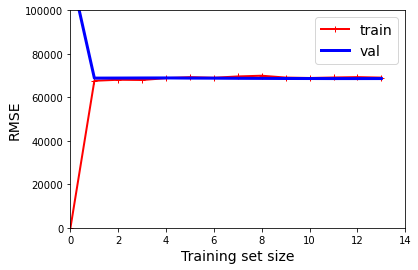

In [72]:
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 14, 0, 100000])
plt.show()

Both in-sample and out-of-sample performance "reach a plateau" with almost no gap between them. The error size is large (the performance is not good). These are the typical characteristic of the learning curves when the model is underfitting the training set.

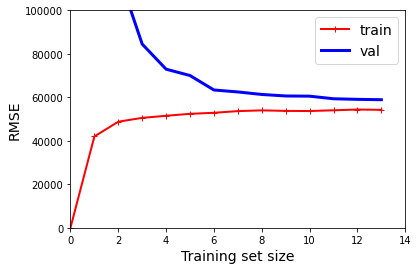

In [75]:
plot_learning_curves(lin_reg_poly, X_poly, y)
plt.axis([0, 14, 0, 100000])
plt.show()

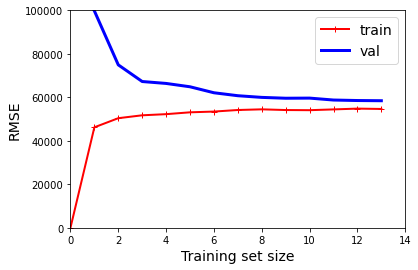

In [76]:
plot_learning_curves(ridge_reg_poly, X_poly, y)
plt.axis([0, 14, 0, 100000])
plt.show()

# 4. Default dataset [17 marks]


In this question you will work with the Default dataset, which is a simulated dataset of credit card default for 10000 customers. Download the data as a csv file from [Canvas](https://canvas.uw.edu/files/90503805/download?download_frd=1). The data was originally obtained from the R library ISLR2, and you can read the documentation for the dataset [here](https://cran.rstudio.com/web/packages/ISLR2/ISLR2.pdf).

You want to predict credit card defaults. The target for this classification problem is `default` and all other variables are the features. 

## (a) [2 marks]
Load the dataset. If it is stored in a file named `Default.csv` in your working directory, this can be done with the code below. Then split the data into a training and a test set, using 20% of the data for the test set. When doing the splitting, use the random seed 42.

In [77]:
import os
data = pd.read_csv("Default.csv")

**[Add your solution here]**

In [78]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)
test_set.head()

,default,student,balance,income
6252,No,No,1435.662933,31507.089277
4684,No,No,771.789347,42139.070269
1731,No,No,0.000000,21809.218509
4742,No,No,113.571264,32803.832648
4521,No,No,1358.132472,49903.597081


In [102]:
X_train = train_set.drop("default", axis=1)
y_train = (train_set["default"] == "Yes").astype(int)

In [103]:
X_test = test_set.drop("default", axis=1)
y_test = (test_set["default"] == "Yes").astype(int)

## (b) [3 marks]

Design a pipeline for preprocessing that applies one hot encoding to the categorical features and a standard scaler to the numerical features.

**[Add your solution here]**

In [106]:
X_num = X_train.drop("student", axis=1)
X_cat = X_train[["student"]]

In [107]:
num_attribs = list(X_num)
cat_attribs = ["student"]

full_pipeline = ColumnTransformer([("num", StandardScaler(), num_attribs), ("cat", OneHotEncoder(), cat_attribs)])

X_train = full_pipeline.fit_transform(X_train)
X_train[:10]

array([[ 0.38108223,  0.03730779,  1.        ,  0.        ],
       [-1.59177438, -0.37009867,  1.        ,  0.        ],
       [ 0.43920243,  0.54017781,  1.        ,  0.        ],
       [-0.14458661,  0.7874204 ,  1.        ,  0.        ],
       [-0.28173517, -0.58938999,  0.        ,  1.        ],
       [ 0.76011857,  1.22069959,  1.        ,  0.        ],
       [-0.74095593, -0.40585885,  1.        ,  0.        ],
       [ 0.90247606,  0.76894008,  1.        ,  0.        ],
       [ 1.02076309, -1.5131229 ,  0.        ,  1.        ],
       [ 2.41707888,  0.22683208,  1.        ,  0.        ]])

## (c) [4 marks]
Train a logistic regression classifier and a `SGDClassifier`, and then using 10-fold cross-validation plot the ROC curve of the classifiers and compute their ROC AUC.

**[Add your solution here]**

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

log_reg = LogisticRegression(C=np.inf)
log_reg.fit(X_train, y_train)

LogisticRegression(C=inf)

In [178]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [179]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

y_scores_log = cross_val_predict(log_reg, X_train, y_train, cv=10, method="predict_proba")[:, 1]
fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_scores_log)
y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=10, method="decision_function")
fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train, y_scores_sgd)

In [180]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

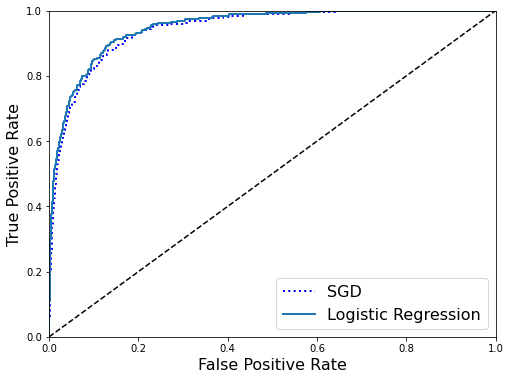

In [181]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_sgd, tpr_sgd, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_log, tpr_log, "Logistic Regression")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [182]:
roc_auc_score(y_train, y_scores_sgd)

0.9433360557488014

In [183]:
roc_auc_score(y_train, y_scores_log)

0.9501229983391307

## (d) [5 marks]

For the classifiers in part (c), plot on the same axes the precision as a function of the threshold and the recall as a function of the threshold. Now suppose you want to achieve a recall of 80%. Consider 4 models:
 1.  The logistic regression classifier in (c),
 2. `SGDClassifier` in (c),
 3. A logistic regression with the argument `class_weight="balanced"`,
 4. `SGDClassifier` with the argument `class_weight="balanced"`.
 
For each of the 4 models, determine the threshold to achieve an 80% recall based on 10-fold cross-validation. Then determine the corresponding precisions. Which model has the best precision?

**[Add your solution here]**

In [184]:
from sklearn.metrics import precision_recall_curve

precisions_log, recalls_log, thresholds_log = precision_recall_curve(y_train, y_scores_log)

In [185]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="lower left", fontsize=16)
    plt.ylim([0, 1])

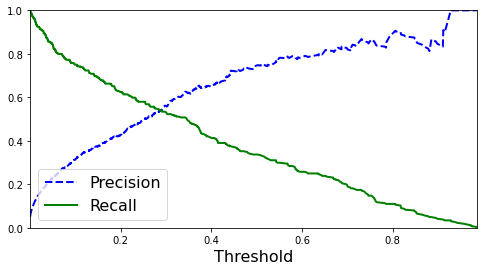

In [186]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_log, recalls_log, thresholds_log)
plt.xlim([thresholds_log.min(), thresholds_log.max()])
plt.show()

In [187]:
def find_precision(precisions, recalls, thresholds, target):
    idx = len(recalls[recalls >= target])
    return thresholds[idx-1], precisions[0:idx].max()

In [188]:
find_precision(precisions_log, recalls_log, thresholds_log, 0.8)

(0.06205012468919842, 0.25118483412322273)

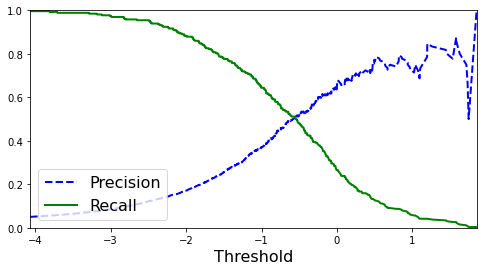

In [189]:
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_train, y_scores_sgd)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_sgd, recalls_sgd, thresholds_sgd)
plt.xlim([thresholds_sgd.min(), thresholds_sgd.max()])
plt.show()

In [190]:
find_precision(precisions_sgd, recalls_sgd, thresholds_sgd, 0.8)

(-1.5825239451635724, 0.24036281179138322)

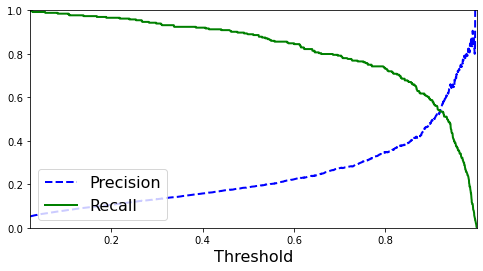

In [191]:
log_reg_balanced = LogisticRegression(C=np.inf, class_weight="balanced")
log_reg_balanced.fit(X_train, y_train)

y_scores_log_balanced = cross_val_predict(log_reg_balanced, X_train, y_train, cv=10, method="predict_proba")[:, 1]
precisions_log_balanced, recalls_log_balanced, thresholds_log_balanced = precision_recall_curve(y_train, y_scores_log_balanced)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_log_balanced, recalls_log_balanced, thresholds_log_balanced)
plt.xlim([thresholds_log_balanced.min(), thresholds_log_balanced.max()])
plt.show()

In [192]:
find_precision(precisions_log_balanced, recalls_log_balanced, thresholds_log_balanced, 0.8)

(0.6593945450761965, 0.2491186839012926)

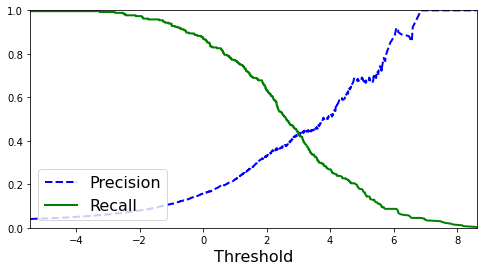

In [193]:
sgd_clf_balanced = SGDClassifier(class_weight="balanced", random_state=42)
sgd_clf_balanced.fit(X_train, y_train)

y_scores_sgd_balanced = cross_val_predict(sgd_clf_balanced, X_train, y_train, cv=10, method="decision_function")
precisions_sgd_balanced, recalls_sgd_balanced, thresholds_sgd_balanced = precision_recall_curve(y_train, y_scores_sgd_balanced)

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions_sgd_balanced, recalls_sgd_balanced, thresholds_sgd_balanced)
plt.xlim([thresholds_sgd_balanced.min(), thresholds_sgd_balanced.max()])
plt.show()

In [194]:
find_precision(precisions_sgd_balanced, recalls_sgd_balanced, thresholds_sgd_balanced, 0.8)

(0.6597875508579181, 0.1968430826369545)

The logistic regression classifier in (c)

## (e) [3 marks]

Fit the best classifier in (d) to the whole training data, and use it to predict on the test set. What is its accuracy, precision, recall, ROC curve and ROC AUC over the test set?

**[Add your solution here]**

In [198]:
best_model = LogisticRegression(C=np.inf)
best_model.fit(X_train, y_train)

X_test = full_pipeline.fit_transform(X_test)
y_pred = best_model.predict(X_test)

In [200]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9695

In [201]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_test, y_pred)

0.6333333333333333

In [202]:
recall_score(y_test, y_pred)

0.2753623188405797

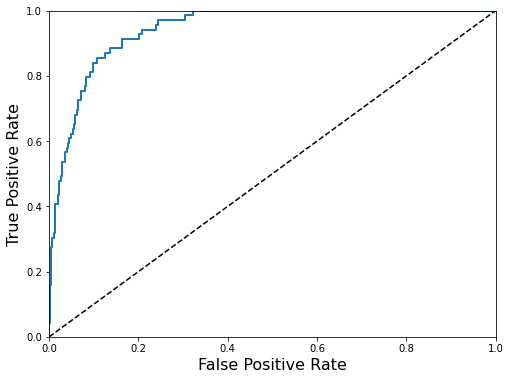

In [207]:
scores = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, scores)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [208]:
roc_auc_score(y_test, scores)

0.9434700050285578